In [1]:
import os
import pandas as pd
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import os
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import FuncFormatter
import plotly.express as px
import tensorboard as tb
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [2]:
# Show ALL rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Optional: prevent line wrapping
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)


# Load tensorboard file after the training


In [3]:
# Functions usefull for the extraction of the information from the event file
def extract_scalars_from_event_file(log_dir):
    # Load TensorBoard event file
    event_acc = EventAccumulator(log_dir)
    event_acc.Reload()

    # List all scalar tags
    scalar_tags = event_acc.Tags().get("scalars", [])

    # Create a dictionary of DataFrames for each tag
    scalar_dataframes = {}

    for tag in scalar_tags:
        events = event_acc.Scalars(tag)
        df = pd.DataFrame({
            "wall_time": [e.wall_time for e in events],
            "step": [e.step for e in events],
            "value": [e.value for e in events],
        })
        scalar_dataframes[tag] = df

    return scalar_dataframes

def list_folders(directory):
    return [name for name in os.listdir(directory)
            if os.path.isdir(os.path.join(directory, name))]

variables = ['rollout/ep_len_mean', 'rollout/ep_rew_mean']

Plot figures

In [4]:
plt.figure()
# Create dataframes
df = pd.DataFrame(columns = ["run", "step", "len", "reward", "algorithm", "grid"])
df_file = pd.DataFrame(columns = ["run", "step", "len", "reward", "algorithm", "grid"])
algorithms = ["specs", "vanilla"]

#Grid to test
grid = 12

directory_path = f"./tb_logs/grid_{grid}/"
len_dir = len(list_folders(directory_path))
print("list_folders", list_folders(directory_path))

for file in list_folders(directory_path):
    dataframes = extract_scalars_from_event_file(directory_path + file)
    df_file["step"] = dataframes['rollout/ep_len_mean']["step"]
    df_file["len"] = dataframes['rollout/ep_len_mean']["value"]
    df_file["reward"] = dataframes['rollout/ep_rew_mean']["value"]


    if isinstance(file[5], int):
        df_file["run"] = int(file[5])
    else:
        df_file["run"] = int(file[7])
    df_file["algorithm"] = "specs" if file[:5] == "specs" else "vanilla"
    df_file["grid"] = grid
    
    df = pd.concat([df,df_file], ignore_index = True)

#print(df)

# === Aggregate Data ===
agg_df = (
    df.groupby(["algorithm", "step"])
    .agg(
        mean_reward=("reward", "mean"),
        std_reward=("reward", "std"),
        mean_len=("len", "mean"),
        std_len=("len", "std"),
    )
    .reset_index()
)

colors = {"vanilla": "royalblue", "specs": "darkorange"}

list_folders ['specs6_2025_10_22_1', 'vanilla5_2025_10_21_1', 'vanilla0_2025_10_17', 'vanilla6_2025_10_21_1', 'specs7_2025_10_22_1', 'specs9_2025_10_23_1', 'vanilla2_2025_10_17', 'vanilla8_2025_10_21_1', 'specs1_2025_10_17', 'vanilla7_2025_10_21_1', 'vanilla4_2025_10_17', 'vanilla1_2025_10_21_1', 'vanilla3_2025_10_17', 'specs5_2025_10_22_1', 'specs0_2025_10_17']


2025-10-23 16:42:22.599953: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-23 16:42:23.118135: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-23 16:42:24.448942: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/tmp/ipykernel_504657/158658704.py:28: FutureWarning: The behavior of DataFrame concatenati

<Figure size 640x480 with 0 Axes>

In [5]:

# ============================================================
# 1️⃣  FIGURE 1 — Average Episode Reward
# ============================================================
fig_reward = go.Figure()

for algorithm in agg_df["algorithm"].unique():
    subset = agg_df[agg_df["algorithm"] == algorithm]

    # Mean line
    fig_reward.add_trace(
        go.Scatter(
            x=subset["step"],
            y=subset["mean_reward"],
            mode="lines",
            name=algorithm,
            line=dict(color=colors.get(algorithm, "gray")),
        )
    )

    # Std shaded region
    fig_reward.add_trace(
        go.Scatter(
            x=list(subset["step"]) + list(subset["step"][::-1]),
            y=list(subset["mean_reward"] + subset["std_reward"]) +
              list(subset["mean_reward"] - subset["std_reward"])[::-1],
            fill="toself",
            fillcolor=f"rgba(65,105,225,0.15)" if algorithm == "vanilla" else "rgba(255,140,0,0.15)",
            line=dict(color="rgba(255,255,255,0)"),
            showlegend=False,
            hoverinfo="skip",
        )
    )

fig_reward.update_layout(
    #title="Training Performance: Average Episode Reward",
    xaxis_title="Training Steps",
    yaxis_title="Average Reward",
    template="plotly_white",
    font=dict(size=13),
    legend_title_text="Algorithm",
    height=500,
    width=950,
)

In [6]:

# ============================================================
# 2️⃣  FIGURE 2 — Average Episode Length
# ============================================================
fig_len = go.Figure()

for algorithm in agg_df["algorithm"].unique():
    subset = agg_df[agg_df["algorithm"] == algorithm]

    # Mean line
    fig_len.add_trace(
        go.Scatter(
            x=subset["step"],
            y=subset["mean_len"],
            mode="lines",
            name=algorithm,
            line=dict(color=colors.get(algorithm, "gray")),
        )
    )

    # Std shaded region
    fig_len.add_trace(
        go.Scatter(
            x=list(subset["step"]) + list(subset["step"][::-1]),
            y=list(subset["mean_len"] + subset["std_len"]) +
              list(subset["mean_len"] - subset["std_len"])[::-1],
            fill="toself",
            fillcolor=f"rgba(0,0,255,0.1)" if algorithm == "vanilla" else "rgba(255,140,0,0.1)",
            line=dict(color="rgba(255,255,255,0)"),
            showlegend=False,
            hoverinfo="skip",
        )
    )
fig_len.update_layout(
    #title="Training Performance: Average Episode Length",
    xaxis_title="Training Steps",
    yaxis_title="Average Episode Length",
    template="plotly_white",
    font=dict(size=13),
    legend_title_text="Algorithm",
    height=500,
    width=950,
)

# ============================================================
# SHOW BOTH
# ============================================================
fig_reward.show()
fig_len.show()

In [7]:
print(agg_df)

     algorithm     step  mean_reward  std_reward     mean_len     std_len
0        specs     2048     0.864844         NaN   173.000000         NaN
1        specs     3072     0.864844         NaN   173.000000         NaN
2        specs     4096     0.864844         NaN   173.000000         NaN
3        specs     5120     0.864844         NaN   173.000000         NaN
4        specs     6144     0.864844         NaN   173.000000         NaN
5        specs     7168     0.864844         NaN   173.000000         NaN
6        specs     8192     0.864844         NaN   173.000000         NaN
7        specs     9216     0.018018    0.044134  1131.604167   49.959385
8        specs    10240     0.018018    0.044134  1131.604167   49.959385
9        specs    11264     0.016016    0.039230  1133.870361   44.408364
10       specs    12288     0.016016    0.039230  1133.870361   44.408364
11       specs    13312     0.016016    0.039230  1133.870361   44.408364
12       specs    14336     0.027040  

# Same Plots with matplotlib

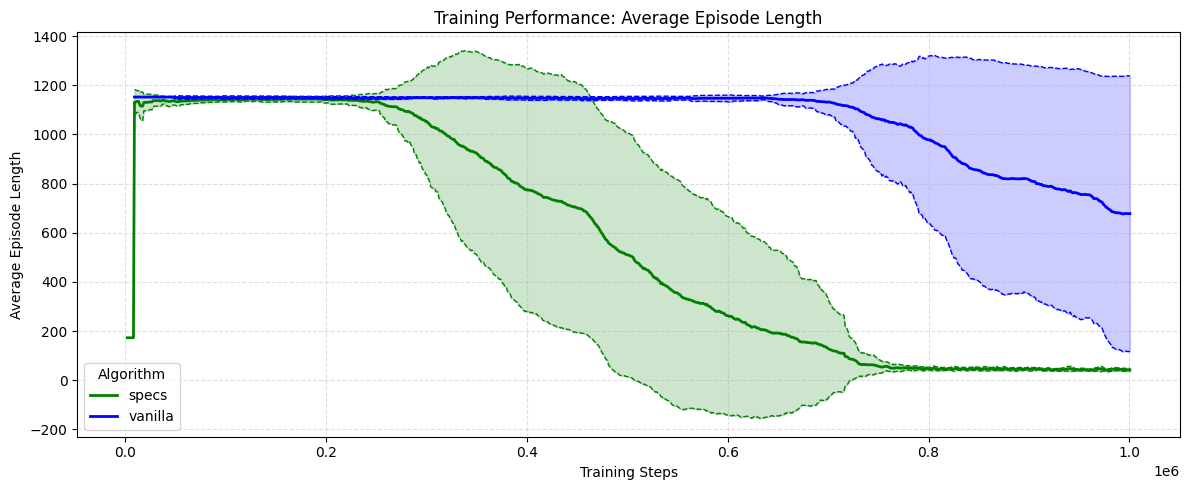

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Colors for consistency
colors = {"vanilla": "blue", "specs": "green"}

plt.figure(figsize=(12, 5))

for algorithm in agg_df["algorithm"].unique():
    subset = agg_df[agg_df["algorithm"] == algorithm]

    x = subset["step"]
    mean = subset["mean_len"]
    std = subset["std_len"]

    # Plot the mean line
    plt.plot(x, mean, label=algorithm, color=colors[algorithm], linewidth=2)

    # Std deviation shaded area
    plt.fill_between(
        x,
        mean - std,
        mean + std,
        color=colors[algorithm],
        alpha=0.2
    )

    # Dashed std boundary lines
    plt.plot(
        x,
        mean + std,
        linestyle="dashed",
        color=colors[algorithm],
        linewidth=1
    )
    plt.plot(
        x,
        mean - std,
        linestyle="dashed",
        color=colors[algorithm],
        linewidth=1
    )

plt.xlabel("Training Steps")
plt.ylabel("Average Episode Length")
plt.title("Training Performance: Average Episode Length")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend(title="Algorithm")
plt.tight_layout()
plt.show()


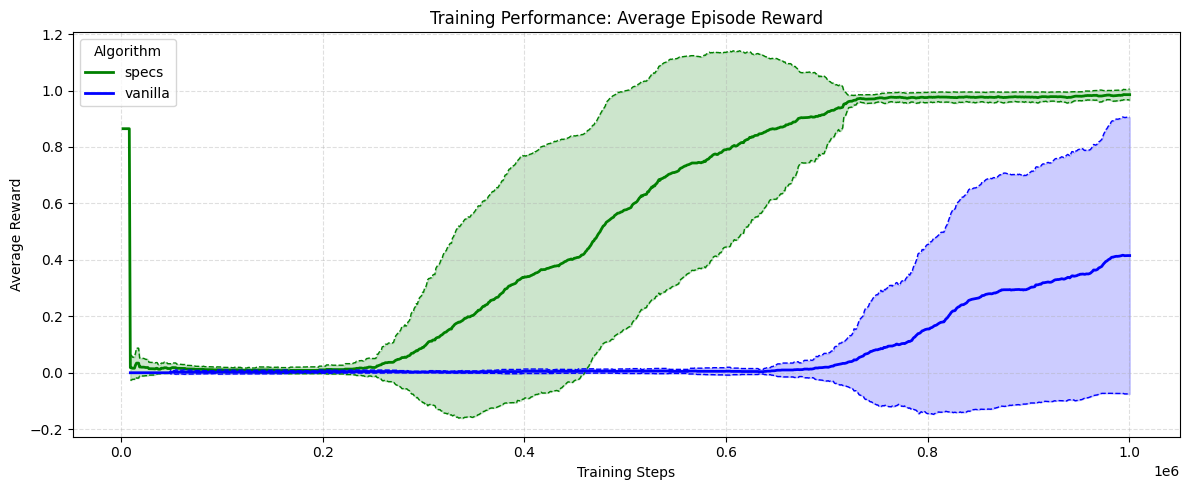

In [9]:

# Ensure same color scheme as before
colors = {"vanilla": "blue", "specs": "green"}

plt.figure(figsize=(12, 5))

for algorithm in agg_df["algorithm"].unique():
    subset = agg_df[agg_df["algorithm"] == algorithm]

    x = subset["step"]
    mean = subset["mean_reward"]
    std = subset["std_reward"]

    # Mean reward line
    plt.plot(
        x, mean,
        label=algorithm,
        color=colors[algorithm],
        linewidth=2
    )

    # Shaded variance area
    plt.fill_between(
        x,
        mean - std,
        mean + std,
        alpha=0.2,
        color=colors[algorithm]
    )

    # Dashed std limits
    plt.plot(
        x,
        mean + std,
        linestyle="dashed",
        color=colors[algorithm],
        linewidth=1
    )
    plt.plot(
        x,
        mean - std,
        linestyle="dashed",
        color=colors[algorithm],
        linewidth=1
    )

plt.xlabel("Training Steps")
plt.ylabel("Average Reward")
plt.title("Training Performance: Average Episode Reward")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend(title="Algorithm")
plt.tight_layout()
plt.show()
